In [29]:
import numpy as np

from itertools import pairwise

from finmarkets import TimeInterval, generate_dates, DiscountCurve

class FloatingRateNote:
    def __init__(self, start_date, maturity, tenor, spot_rate):
        self.dates = generate_dates(start_date, maturity, tenor)
        self.spot_rate = spot_rate

    def npv(self, dc, obs_date):
        value = 0.0
        last_date = self.dates[-1]

        for d0, d1 in pairwise(self.dates):
            if obs_date >= d1:
                continue          
            elif obs_date <= d0:
                tau = (d1 - d0).days / 365                
                F = (dc.df(d0) / dc.df(d1) - 1) / tau
                value += tau * F * dc.df(d1) / dc.df(obs_date)
            elif d0 < obs_date < d1:
                if d0 == self.dates[0]:
                    current_fixing = self.spot_rate
                else:
                    t = (d0 - self.dates[0]).days/365
                    current_fixing = self.spot_rate #-np.log(dc.df(d0))/t
                tau = (d1 - obs_date).days / 365
                value += tau * current_fixing * dc.df(d1) / dc.df(obs_date) 
            else:
                raise ValueError("Unexpected date alignment!")
        value += dc.df(last_date)        
        return value

In [30]:
import pandas as pd, numpy as np

from datetime import date
from dateutil.relativedelta import relativedelta

df_rates = pd.read_csv("https://raw.githubusercontent.com/matteosan1/advanced_financial_modeling/master/input_files/libor.csv")

obs_date = date.today()
#pillars = [obs_date + TimeInterval(f"{t}M") for t in df_rates['T']]
pillars = [obs_date + TimeInterval(f"{t}y") for t in range(3)]
dfs = [np.exp(-0.065*t) for t in range(3)]
dc = DiscountCurve(pillars, dfs)
frn = FloatingRateNote(obs_date, "6m", "3m", 0.065)
print (frn.dates)

prices = []
current_date = obs_date + relativedelta(days=1)
#end = 360*2 + 2
# d += relativedelta(days=start)

i=0
while current_date <= frn.dates[-1]:
    price = frn.npv(dc, current_date)
    prices.append(price)
    current_date +=relativedelta(days=1)
      

[datetime.date(2026, 2, 5), datetime.date(2026, 5, 5), datetime.date(2026, 8, 5)]


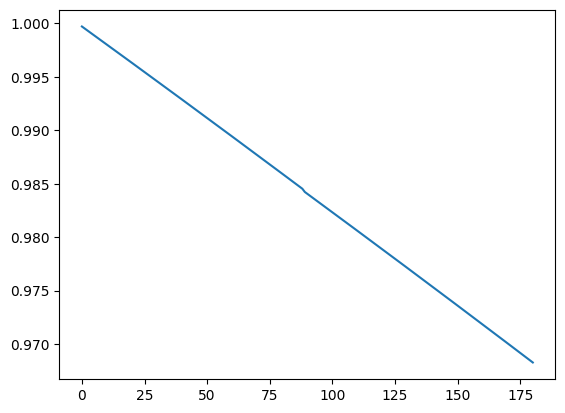

In [31]:
from matplotlib import pyplot as plt

plt.plot(np.arange(0, len(prices), 1), prices)
plt.show()

In [32]:
import numpy as np
from dataclasses import dataclass
from typing import List
from datetime import datetime, timedelta

@dataclass
class FRN:
    nominal: float
    dates: List[datetime]  # Payment dates (d0, d1, d2...)
    
    def get_npv(self, obs_date: datetime, yield_curve, current_fixing: float):
        value = 0.0
        
        for i in range(1, len(self.dates)):
            d_start = self.dates[i-1]
            d_end = self.dates[i]
            
            if obs_date >= d_end:
                continue  # Coupon already paid
                
            tau = (d_end - d_start).days / 360
            df = yield_curve.df(obs_date, d_end)
            
            # Reset Logic
            if d_start <= obs_date < d_end:
                # Mid-period: Rate is fixed
                coupon = self.nominal * current_fixing * tau
            else:
                # Future: Rate is implied by the forward curve
                fwd = (yield_curve.df(obs_date, d_start) / yield_curve.df(obs_date, d_end) - 1) / tau
                coupon = self.nominal * fwd * tau
                
            value += coupon * df
            
        # Add Principal at the end
        value += self.nominal * yield_curve.df(obs_date, self.dates[-1])
        return value

class SimpleCurve:
    def __init__(self, r): self.r = r
    def df(self, start, end):
        t = (end - start).days / 360
        return np.exp(-self.r * t)

In [33]:
# Setup
start = datetime(2024, 1, 1)
pay_dates = [start + timedelta(days=90*i) for i in range(5)]
bond = FRN(nominal=100, dates=pay_dates)
curve = SimpleCurve(r=0.03)

# Data for plot
timeline = [start + timedelta(days=i) for i in range(360)]
npvs = []

for t in timeline:
    # Find the applicable fixing (the rate at the start of the current period)
    # For illustration, we assume the fixing matches the curve at that time
    fixing = 0.03 
    npvs.append(bond.get_npv(t, curve, current_fixing=fixing))

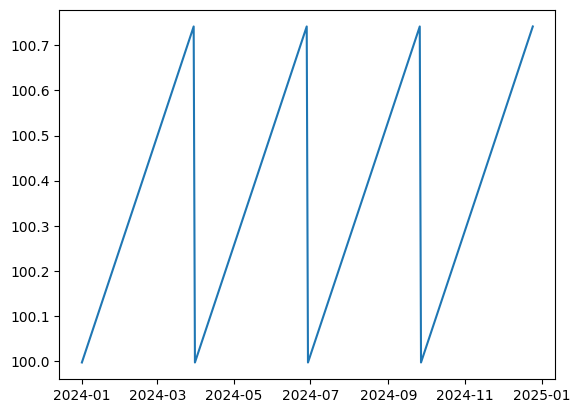

In [34]:
from matplotlib import pyplot as plt

plt.plot(timeline, npvs)
plt.show()